In [6]:
import os
import sys
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

In [7]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

if (dir := str(Path(os.getcwd()).parent)) not in sys.path:
    sys.path.append(dir)
sys.path

['c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs\\notebooks',
 'C:\\Users\\podov\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip',
 'C:\\Users\\podov\\AppData\\Local\\Programs\\Python\\Python39\\DLLs',
 'C:\\Users\\podov\\AppData\\Local\\Programs\\Python\\Python39\\lib',
 'C:\\Users\\podov\\AppData\\Local\\Programs\\Python\\Python39',
 'c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs\\venv',
 '',
 'c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs\\venv\\lib\\site-packages',
 'c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs\\venv\\lib\\site-packages\\win32',
 'c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs\\venv\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs\\venv\\lib\\site-packages\\Pythonwin',
 'c:\\Users\\podov\\Desktop\\Andrey\\Универ\\Машинное обучение\\ml-labs']

In [8]:
from mylib.metrics import Metrics, CMetrics

In [9]:
SEED = 73

np.random.seed = SEED

In [10]:
wine = pd.read_csv('../data/wine_preprocessed.csv', sep=';')
rain = pd.read_csv('../data/rain_preprocessed.csv', sep=';')

## Разделение

In [11]:
X_wine = wine.drop(['quality'], axis=1)
y_wine = wine['quality']
X_wine.shape, y_wine.shape

((6497, 12), (6497,))

In [12]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine, y_wine, test_size=0.33)

In [13]:
rain['RainTomorrow'].value_counts()

0    113583
1     31877
Name: RainTomorrow, dtype: int64

In [14]:
rain0 = rain[rain['RainTomorrow'] == 0]
rain1 = rain[rain['RainTomorrow'] == 1]

rain0 = resample(rain0,
                 replace=False,
                 n_samples=len(rain1),
                 random_state=73)

rain = pd.concat([rain1, rain0])
print(rain['RainTomorrow'].value_counts())

1    31877
0    31877
Name: RainTomorrow, dtype: int64


In [15]:
X_rain = rain.drop(columns=['RainTomorrow'])
y_rain = rain['RainTomorrow']
X_rain.shape, y_rain.shape

((63754, 23), (63754,))

In [16]:
# sm = SMOTE(random_state=73, k_neighbors=5)
# X_rain, y_rain = sm.fit_resample(X_rain, y_rain)
# X_rain.shape, y_rain.shape

In [17]:
X_rain_train, X_rain_test, y_rain_train, y_rain_test = train_test_split(X_rain, y_rain, test_size=0.33, random_state=SEED)

In [18]:
print_r_metrics = lambda true, pred: Metrics(true, pred)()
print_c_metrics = lambda true, pred: CMetrics(true, pred)()


## Обучение

In [46]:
params = {
    'random_state': [SEED],
    'max_depth': range(5, 8),
}

dtr = GridSearchCV(DecisionTreeRegressor(), params).fit(X_wine_train, y_wine_train)

print(dtr.best_params_)
print_r_metrics(y_wine_test, dtr.predict(X_wine_test))

{'max_depth': 6, 'random_state': 73}
MAE:	0.5806070419662976
MSE:	0.549637423585852
RMSE:	0.7413753594407168
MAPE:	0.10416919409448437
R^2:	0.26078251935546726


In [47]:
params = {
    'random_state': [SEED],
    'max_depth': range(5, 8),
}

dtc = GridSearchCV(DecisionTreeClassifier(), params).fit(X_rain_train, y_rain_train)

print(dtc.best_params_)
print_c_metrics(y_rain_test, dtc.predict(X_rain_test))

{'max_depth': 7, 'random_state': 73}
	precision	recall	f1-score
0	     0.77	  0.75	    0.76
1	     0.76	  0.77	    0.77
accuracy			    0.76



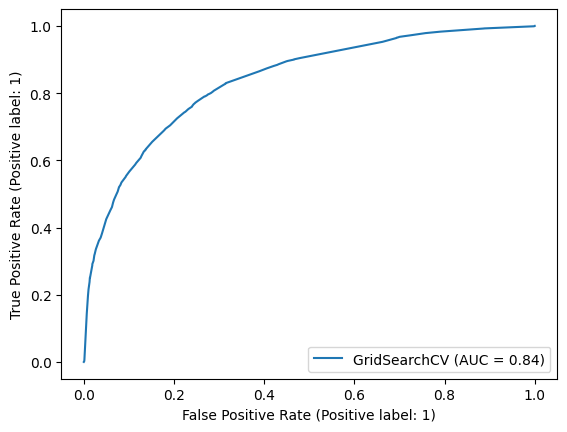

In [66]:
RocCurveDisplay.from_estimator(dtc, X_rain_test, y_rain_test)

In [48]:
params = {
    'random_state': [SEED],
    'n_estimators': range(9, 12),
}

br = GridSearchCV(BaggingRegressor(), params).fit(X_wine_train, y_wine_train)

print(br.best_params_)
print_r_metrics(y_wine_test, br.predict(X_wine_test))

{'n_estimators': 11, 'random_state': 73}
MAE:	0.4644204280567916
MSE:	0.4072973858097825
RMSE:	0.6381985473266
MAPE:	0.08368659959569048
R^2:	0.4522182542681549


In [49]:
params = {
    'random_state': [SEED],
    'n_estimators': range(9, 12),
}

bc = GridSearchCV(BaggingClassifier(), params).fit(X_rain_train, y_rain_train)

print(bc.best_params_)
print_c_metrics(y_rain_test, bc.predict(X_rain_test))

{'n_estimators': 11, 'random_state': 73}
	precision	recall	f1-score
0	     0.77	  0.77	    0.77
1	     0.77	  0.77	    0.77
accuracy			    0.77



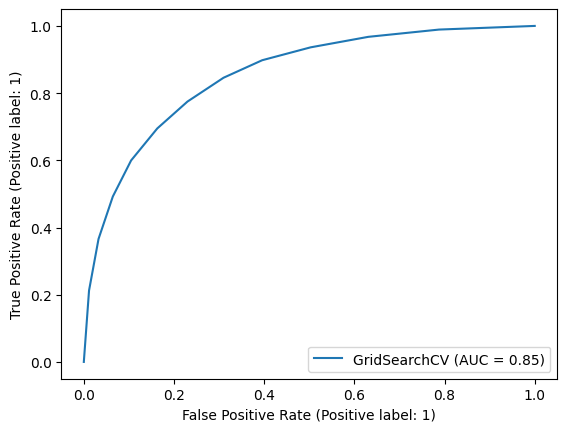

In [65]:
RocCurveDisplay.from_estimator(bc, X_rain_test, y_rain_test)

In [50]:
params = {
    'random_state': [SEED],
    'max_depth': range(5, 8),
}

gbr = GridSearchCV(GradientBoostingRegressor(), params).fit(X_wine_train, y_wine_train)

In [51]:
print(gbr.best_params_)
print_r_metrics(y_wine_test, gbr.predict(X_wine_test))

{'max_depth': 7, 'random_state': 73}
MAE:	0.46990801301439944
MSE:	0.3961667221885944
RMSE:	0.6294177644367804
MAPE:	0.0843706696248726
R^2:	0.4671880885022883


In [52]:
params = {
    'random_state': [SEED],
    'max_depth': range(5, 8),
}

gbc = GridSearchCV(GradientBoostingClassifier(), params).fit(X_rain_train, y_rain_train)

print(gbc.best_params_)
print_c_metrics(y_rain_test, gbc.predict(X_rain_test))

{'max_depth': 7, 'random_state': 73}
	precision	recall	f1-score
0	     0.79	  0.80	    0.80
1	     0.80	  0.80	    0.80
accuracy			    0.80



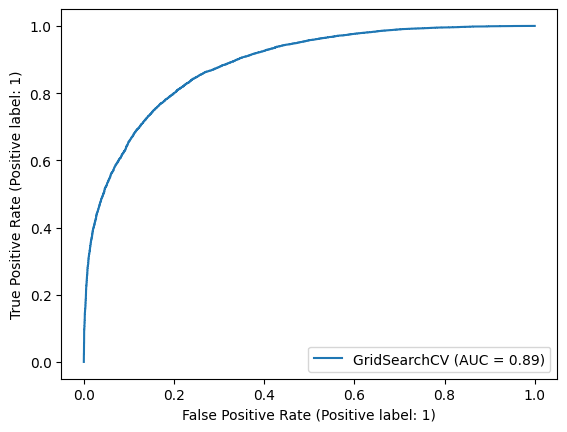

In [64]:
RocCurveDisplay.from_estimator(gbc, X_rain_test, y_rain_test)

In [53]:
estimators = [
    ('br', br),
    ('gbr', gbr)
]

sr = StackingRegressor(estimators=estimators).fit(X_wine_train, y_wine_train)

print_r_metrics(y_wine_test, sr.predict(X_wine_test))

MAE:	0.45713486627199795
MSE:	0.3819157384483829
RMSE:	0.6179933158606029
MAPE:	0.08213558586501185
R^2:	0.48635449865758207


In [55]:
estimators = [
    ('bc', bc),
    ('dtc', dtc)
]

sc = StackingClassifier(estimators=estimators).fit(X_rain_train, y_rain_train)

print_c_metrics(y_rain_test, sc.predict(X_rain_test))

	precision	recall	f1-score
0	     0.77	  0.78	    0.77
1	     0.78	  0.78	    0.78
accuracy			    0.78



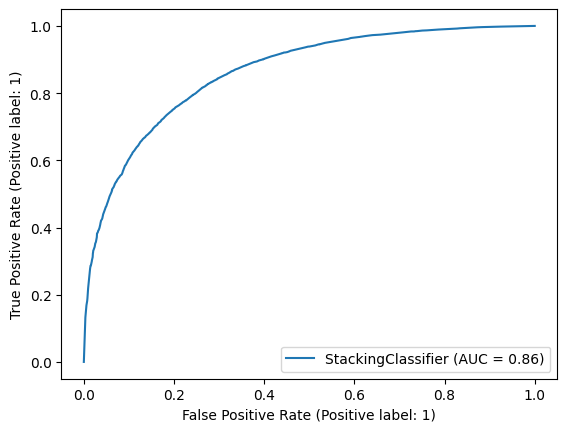

In [63]:
RocCurveDisplay.from_estimator(sc, X_rain_test, y_rain_test)

In [56]:
params = {
    'random_state': [SEED],
    'max_depth': range(3, 8),
}

xgbr = GridSearchCV(XGBRegressor(), params).fit(X_wine_train, y_wine_train)

print(xgbr.best_params_)
print_r_metrics(y_wine_test, xgbr.predict(X_wine_test))

{'max_depth': 6, 'random_state': 73}
MAE:	0.47707661715420807
MSE:	0.4251207112530425
RMSE:	0.6520128152521563
MAPE:	0.0856309221537779
R^2:	0.4282473360491622


In [57]:
params = {
    'random_state': [SEED],
    'max_depth': range(3, 8),
}

xgbc = GridSearchCV(XGBClassifier(), params).fit(X_rain_train, y_rain_train)

print(xgbc.best_params_)
print_c_metrics(y_rain_test, xgbc.predict(X_rain_test))

{'max_depth': 6, 'random_state': 73}
	precision	recall	f1-score
0	     0.80	  0.80	    0.80
1	     0.80	  0.80	    0.80
accuracy			    0.80



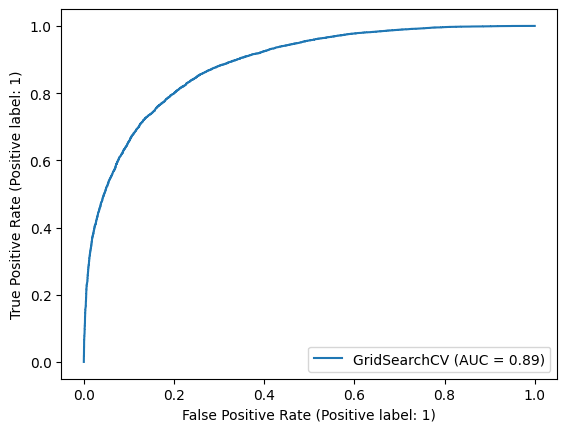

In [62]:
RocCurveDisplay.from_estimator(xgbc, X_rain_test, y_rain_test)

In [58]:
cbr = CatBoostRegressor(random_state=SEED, verbose=False).fit(X_wine_train, y_wine_train)

print_r_metrics(y_wine_test, cbr.predict(X_wine_test))

MAE:	0.47905280790323695
MSE:	0.3901949763238065
RMSE:	0.6246558863276697
MAPE:	0.08580778592380782
R^2:	0.4752195993561492


In [59]:
cbc = CatBoostClassifier(random_state=SEED, verbose=False).fit(X_rain_train, y_rain_train)

print_c_metrics(y_rain_test, cbc.predict(X_rain_test))

	precision	recall	f1-score
0	     0.80	  0.81	    0.81
1	     0.81	  0.80	    0.81
accuracy			    0.81



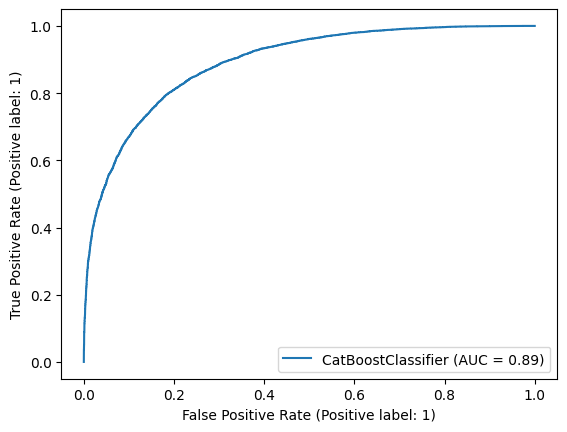

In [61]:
RocCurveDisplay.from_estimator(cbc, X_rain_test, y_rain_test)

## Свой сад

In [67]:
from mylib.cart import CART

In [72]:
cart_r = CART('R', max_depth=5).fit(np.array(X_wine_train), np.array(y_wine_train))
cart_r_pred = cart_r.predict(X_wine_test)
cart_r_pred

array([5.54455446, 5.62864078, 5.70833333, ..., 5.70833333, 7.01923077,
       5.62864078])

In [73]:
print_r_metrics(y_wine_test, cart_r_pred)

MAE:	0.5865113112202837
MSE:	0.5655895800185565
RMSE:	0.7520568994554577
MAPE:	0.10521323199044846
R^2:	0.2393281707558046


In [79]:
cart_c = CART('C', max_depth=5).fit(np.array(X_rain_train[:100]), np.array(y_rain_train[:100]))
print_c_metrics(y_rain_test, cart_c.predict(X_rain_test))

	precision	recall	f1-score
0	     0.64	  0.68	    0.66
1	     0.67	  0.63	    0.65
accuracy			    0.65



In [80]:
cart_c = CART('C', max_depth=5).fit(np.array(X_rain_train[:1000]), np.array(y_rain_train[:1000]))
cart_c_pred = cart_c.predict(X_rain_test)
cart_c_pred

array([0., 1., 0., ..., 1., 0., 0.])

In [81]:
print_c_metrics(y_rain_test, cart_c_pred)

	precision	recall	f1-score
0	     0.68	  0.83	    0.75
1	     0.79	  0.62	    0.69
accuracy			    0.72



## Бэггинг

In [19]:
from mylib.bagging import Bagging

In [20]:
my_br = Bagging('R', DecisionTreeRegressor, n_estimators=11).fit(X_wine_train, y_wine_train)
print_r_metrics(y_wine_test, my_br.predict(np.array(X_wine_test)))

MAE:	0.4541216359398177
MSE:	0.38977826581132363
RMSE:	0.6243222451677688
MAPE:	0.08128654174108718
R^2:	0.47297193105517743


In [22]:
my_br = Bagging('R', BaggingRegressor, n_estimators=11).fit(X_wine_train, y_wine_train)
print_r_metrics(y_wine_test, my_br.predict(np.array(X_wine_test)))

MAE:	0.45896588260224624
MSE:	0.3736211061665607
RMSE:	0.6112455367252678
MAPE:	0.08214829783011601
R^2:	0.4948183945297072


In [95]:
my_bc = Bagging('C', DecisionTreeClassifier, n_estimators=11).fit(X_rain_train, y_rain_train)
print_c_metrics(y_rain_test, my_bc.predict(np.array(X_rain_test)))


	precision	recall	f1-score
0	     0.77	  0.78	    0.77
1	     0.78	  0.77	    0.78
accuracy			    0.78



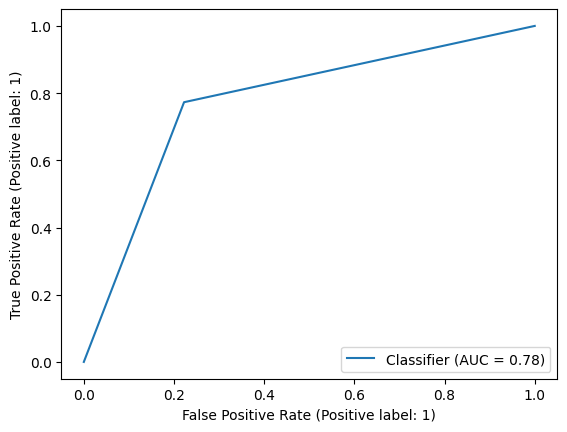

In [97]:
RocCurveDisplay.from_predictions(y_rain_test, my_bc.predict(np.array(X_rain_test)))